Creating metadata between samples and corresponding population



In [68]:
from Bio import SeqIO
from Bio import Entrez
from Bio.SeqFeature import SeqFeature, FeatureLocation
import re
import pandas as pd

def create_metadata(name, startId, lastId):
    lastId = lastId + 1
    access_id = []
    population = []
    Entrez.email = "syuzi.matevosyan1802@gmail.com"
    for id in range(startId, lastId):
        filename = name + str(id)
        net_handle = Entrez.efetch(
            db="nucleotide", id=filename, rettype="gb", retmode="text"
        )
        record = SeqIO.read(net_handle, "gb")
        access_id.append(filename)
        population.append(record.features[0].qualifiers.get("isolate")[0])
    
    list_of_tuples = list(zip(access_id, population))
    metadata = pd.DataFrame(list_of_tuples,
                  columns=['access_id', 'population'])
    return metadata



In [ ]:
df1 = create_metadata("MK491", 355, 495)


In [ ]:
df2 = create_metadata("HM852", 756, 902)


In [ ]:
df3 = create_metadata("KC911", 275, 629)

In [ ]:
df4 = create_metadata("MF362", 744, 949)

In [20]:
frames = [df1, df2, df3, df4]

result = pd.concat(frames)

Saving in metadata.csv file

In [21]:
result.to_csv("metadata.csv")

Displaying as pandas array

In [9]:
meta = pd.read_csv("metadata.csv", header=None)
meta

,0,1,2
0,NaN,access_id,population
1,0.0,MK491355,Armenian individual
2,1.0,MK491356,Armenian individual
3,2.0,MK491357,Armenian individual
4,3.0,MK491358,Armenian individual
...,...,...,...
845,201.0,MF362945,Erzrum_81
846,202.0,MF362946,Erzrum_82
847,203.0,MF362947,Erzrum_84
848,204.0,MF362948,Erzrum_85


Creating binary matrix that indicates the presence (1) or absence (0) of each target gene variant for each sample.

In [70]:
import pandas as pd
import gzip
import re

# Function to extract VCF column names from a gzipped VCF file
def get_vcf_names(vcf_path):
    with gzip.open(vcf_path, "rt") as ifile:
        for line in ifile:
            if line.startswith("#CHROM"):
                vcf_names = [x for x in line.split('\t')]
                break
    ifile.close()
    return vcf_names

# Function to create a DataFrame from a gzipped VCF file

def create_vcf(vcf_path):
    vcf = pd.read_csv(vcf_path, compression='gzip', comment='#', delim_whitespace=True, header=None, names=names)
    return vcf

# List of target genes

genes = ["ND1", "ND2", "COX1", "COX2", "ATP6", "ATP8", "ND3", "ND4", "ND4L", "ND5", "ND6", "CYTB", "COX3"]

# Lists to store patient IDs and corresponding VCF file paths

patients = []
path_name = []

# Generate patient IDs and VCF file paths

for i in range(355, 496):
    patients.append('MK491' + str(i)) 
    path_name.append('../samples/arm_samples/anno/MK491' + str(i) + '.vcf.anno.vcf.gz')


for i in range(756, 902):
    patients.append('HM852' + str(i)) 
    path_name.append('../samples/other_samples/HM852' + str(i) + '.vcf.anno.vcf.gz')


for i in range(275, 629):
    patients.append("KC911" + str(i)) 
    path_name.append('../samples/other_samples/KC911' + str(i) + '.vcf.anno.vcf.gz')


for i in range(744, 949):
    patients.append('MF362' + str(i)) 
    path_name.append('../samples/other_samples/MF362' + str(i) + '.vcf.anno.vcf.gz')
# Create an empty DataFrame to store matrix data

matrix_data = pd.DataFrame(index=patients, columns=genes, dtype=int)
matrix_data = matrix_data.fillna(0)

# Function to find the first gene match in an input string

def find_first_gene_match(input_string):
    return next((gene for gene in genes if gene in input_string), None)


# Process each VCF file

for (file, patient) in zip(path_name, patients):
    names = get_vcf_names(file)  # Get VCF column names
    vcf = create_vcf(file)       # Create DataFrame from VCF file
    for gene in genes:
        # Check if gene is present in any INFO column, update matrix_data accordingly
        if (vcf["INFO"].apply(lambda x: find_first_gene_match(x)).str.contains(gene).sum() > 0):
            matrix_data.loc[patient].at[gene] = 1
        else:
            matrix_data.loc[patient].at[gene] = 0


print(matrix_data)

          ND1  ND2  COX1  COX2  ATP6  ATP8  ND3  ND4  ND4L  ND5  ND6  CYTB  \
MK491355  1.0  1.0   1.0   1.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MK491356  1.0  1.0   1.0   1.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MK491357  1.0  0.0   1.0   0.0   0.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MK491358  1.0  0.0   1.0   1.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MK491359  1.0  0.0   0.0   1.0   0.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
...       ...  ...   ...   ...   ...   ...  ...  ...   ...  ...  ...   ...   
MF362944  1.0  1.0   1.0   1.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MF362945  1.0  0.0   1.0   1.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MF362946  1.0  1.0   1.0   0.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MF362947  1.0  1.0   1.0   0.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   
MF362948  1.0  1.0   1.0   0.0   1.0   0.0  1.0  1.0   0.0  0.0  0.0   0.0   

          COX3  
MK491355   0.0  
MK491356   0.0  
MK491357   0

In [73]:
matrix_data.to_csv("matrix.csv")

Visualizing matrix.csv

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt 


<Axes: >

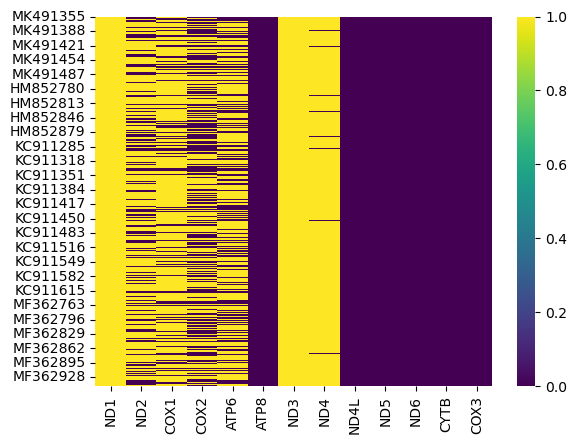

In [19]:
sns.heatmap(matrix_data, cmap="viridis")

Performing clustering 

In [75]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Number of clusters
num_clusters = 3
n_init = 10
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init = n_init, random_state=0)
#means.fit(matrix_data)
cluster_labels = kmeans.fit_predict(matrix_data)

# Add cluster labels to the data
data_with_clusters = pd.DataFrame(matrix_data)
data_with_clusters['Cluster'] = cluster_labels


data_with_clusters

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster
MK491355,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
MK491356,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
MK491357,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
MK491358,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
MK491359,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
MF362945,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2
MF362946,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
MF362947,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0


Visualizing clustered results

In [76]:
data_with_clusters_modify = data_with_clusters.copy()
data_with_clusters_modify['Cluster'] = data_with_clusters_modify['Cluster'].replace(0, 3)

for i in range(len(data_with_clusters_modify)):
    data_with_clusters_modify.iloc[i,:] = data_with_clusters_modify.iloc[i,:].replace(1,data_with_clusters_modify.iloc[i,13])

data_with_clusters_modify

,ND1,ND2,COX1,COX2,ATP6,ATP8,ND3,ND4,ND4L,ND5,ND6,CYTB,COX3,Cluster
MK491355,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2
MK491356,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2
MK491357,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
MK491358,2.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2
MK491359,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MF362944,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2
MF362945,2.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2
MF362946,3.0,3.0,3.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3
MF362947,3.0,3.0,3.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3


<Axes: >

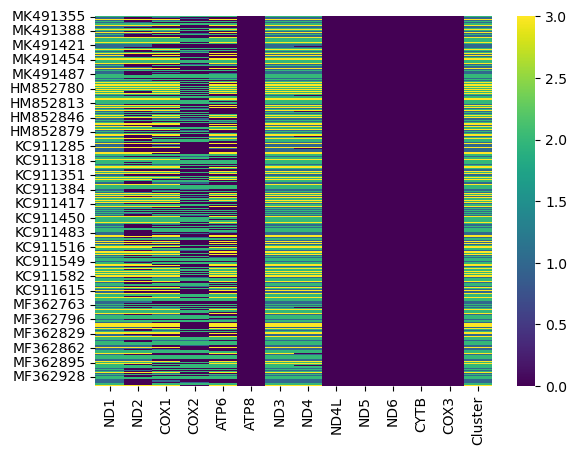

In [77]:
sns.heatmap(data_with_clusters_modify, cmap="viridis")

In [ ]:
from adjustText import adjust_text

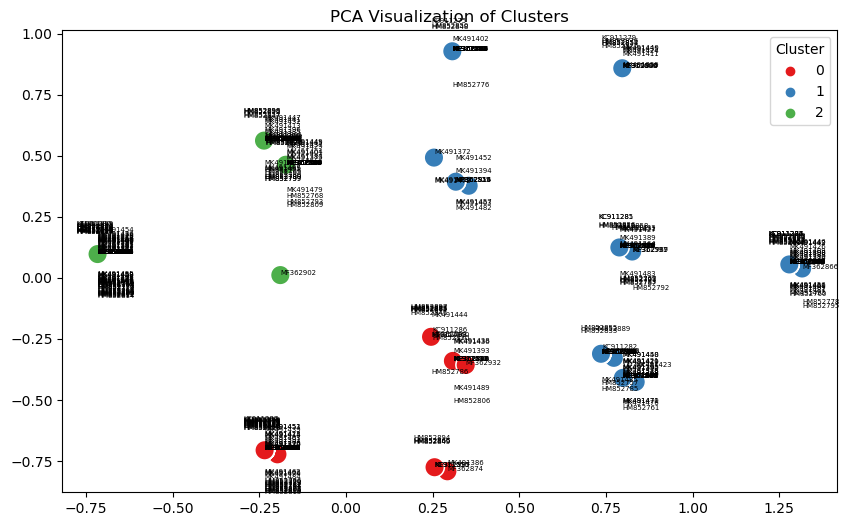

In [153]:
from matplotlib.transforms import offset_copy
from adjustText import adjust_text
# Visualize clusters using PCA
pca = PCA(2)
data_2d = pca.fit_transform(matrix_data)
#print(data_2d[:, 1])

x=data_2d[:, 0]
y=data_2d[:, 1]
types = matrix_data.index.tolist()

plt.figure(figsize=(10, 6))

sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=cluster_labels, palette='Set1', s = 200)
plt.title('PCA Visualization of Clusters')
#plt.xlabel('Principal Component 1')
#plt.ylabel('Principal Component 2')
texts = []
offset = 0.0009
offsetx = 0.0004


for i, txt in enumerate(types):
    #if (i > (len(types) / 4)):
    #if (y[i] < 200):
    #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=i, units='points')
    #elif (i < 300):
      #  offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=-10, y=i-200, units='points')
    #elif (i < 400):
     #   offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=15 - i * 0.0009, units='points')
    #pastx = x[i-1]
    #pasty = y[i-1]
    #if ((x[i] - pastx > 0) and (y[i] - pasty > 0)):
     #    offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=0, y=0, units='points')
    #else:
    #    if ((x[i] - pastx <= 0) and (y[i] - pasty <= 0)):
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=i * 0.05, units='points')
    #    else:
    #        offset_transform = offset_copy(plt.gca().transData, fig=plt.gcf(), x=5, y=-i*0.05, units='points')
    if (i < 100):
        plt.text(x[i], y[i] + i * offset, txt, fontsize=5)
    elif (i < 200):
        plt.text(x[i], y[i] - i * offset, txt, fontsize=5)
    elif (i < 300):
        plt.text(x[i] - 0.06, y[i] + i * offsetx, txt, fontsize=5)
    elif (i > 500):
        plt.text(x[i], y[i], txt, fontsize=5)
    #elif (i < (len(types) / 3)):
     #   plt.text(x[i] - i * offsetx, y[i], txt)
    #elif (i < (len(types) / 2)):
     #   plt.text(x[i] - i * offsetx, y[i] - i * offsetx, txt)
    #else:
     #   plt.text(x[i], y[i] - i * offsetx, txt)
    #plt.scatter(x, y, marker='x', color='red')

plt.legend(title='Cluster')
plt.show()

Another way for matrix_data visualization

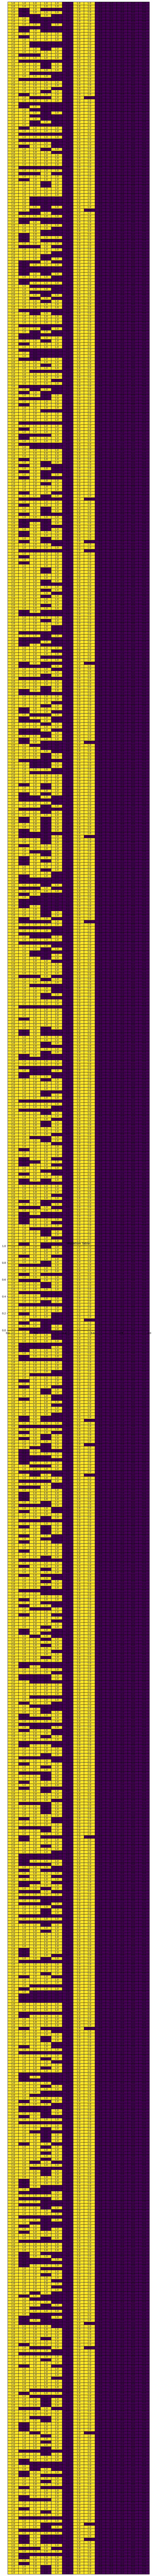

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Convert data to a NumPy array
data_array = np.array(matrix_data)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a table with color-coded cells
ax.table(cellText=data_array, cellColours=plt.cm.viridis(data_array), cellLoc='center', loc='center')

# Remove axes
ax.axis(" ND1  ND2  COX1  COX2  ATP6  ATP8  ND3  ND4  ND4L  ND5  ND6  CYTB ")

# Add a title
plt.title('Mutation Table')

# Show the plot
plt.show()
